## 1. Decision Trees

In [1]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def visualize_decision_tree(model, original_features, figsize=(20, 12), max_depth=4):
    """
    Visualize a DecisionTreeRegressor, whether inside a Pipeline or standalone.
    
    Parameters
    ----------
    model : Pipeline or DecisionTreeRegressor
    original_features : list[str]
        Columns provided to the model, including the genre column if present.
    """
    
    # -------------------------------------
    # 1. Model is a Pipeline
    # -------------------------------------
    if hasattr(model, "named_steps"):
        tree = model.named_steps["tree"]

        # If it has preprocessing
        if "preprocess" in model.named_steps:
            preprocess = model.named_steps["preprocess"]

            # Which columns were treated as categorical?
            if "cat" in preprocess.named_transformers_:
                # Extract OHE-expanded names
                ohe = preprocess.named_transformers_["cat"]
                categorical_original_col = preprocess.transformers_[0][2]  # list of categorical cols
                cat_features = ohe.get_feature_names_out(categorical_original_col)

                # Numeric features (other transformers)
                numeric_features = []
                for name, transformer, cols in preprocess.transformers_:
                    if name != "cat":
                        numeric_features.extend(cols)

                final_features = list(cat_features) + list(numeric_features)

            else:
                # No categorical transform
                final_features = original_features

        else:
            # Pipeline but no preprocessing
            final_features = original_features

    # -------------------------------------
    # 2. Raw DecisionTreeRegressor
    # -------------------------------------
    else:
        tree = model
        final_features = original_features

    # -------------------------------------
    # Final sanity check
    # -------------------------------------
    n_tree_features = tree.n_features_in_
    if len(final_features) != n_tree_features:
        print("Warning: feature name length mismatch!")
        print("Tree expects:", n_tree_features)
        print("Provided:", len(final_features))
        print("Adjusting to match tree input...")

        # Fix by truncating or padding
        if len(final_features) > n_tree_features:
            final_features = final_features[:n_tree_features]
        else:
            final_features = final_features + [f"feat_{i}" for i in range(n_tree_features - len(final_features))]

    # -------------------------------------
    # Plot
    # -------------------------------------
    plt.figure(figsize=figsize)
    plot_tree(
        tree,
        feature_names=final_features,
        filled=True,
        rounded=True,
        max_depth=max_depth,
        fontsize=10,
    )
    plt.show()


In [2]:
class VizNode:
    def __init__(self, feature=None, threshold=None, samples=None, value=None,
                 left=None, right=None, collapsed=False,
                 collapsed_next_feature=None, collapsed_next_threshold=None):
        self.feature = feature
        self.threshold = threshold
        self.samples = samples
        self.value = value

        self.left = left      # TRUE branch
        self.right = right    # FALSE branch (may be collapsed)

        self.collapsed = collapsed
        self.collapsed_next_feature = collapsed_next_feature
        self.collapsed_next_threshold = collapsed_next_threshold


def get_expanded_feature_names(model, raw_feature_names):
    # Pipeline?
    if hasattr(model, "named_steps"):
        preprocess = model.named_steps.get("preprocess", None)
        if preprocess is None:
            return raw_feature_names  # no preprocessing

        ohe = preprocess.named_transformers_["cat"]
        cat_cols = preprocess.transformers_[0][2]
        ohe_features = list(ohe.get_feature_names_out(cat_cols))

        # numeric columns:
        numeric_features = []
        for name, transformer, cols in preprocess.transformers_:
            if name != "cat":
                numeric_features.extend(cols)

        return ohe_features + numeric_features

    # Raw DecisionTreeRegressor
    return raw_feature_names


def build_viz_tree(tree, node_id, feature_names, depth=0, max_depth=None):
    """
    Convert sklearn tree to VizNode structure, with:
      - full expansion on TRUE branch
      - collapsed single-node on FALSE branch
      - safe recursion with max_depth cutoff
    """

    # ----- BOUNDS CHECK -----
    if node_id < 0 or node_id >= tree.node_count:
        return VizNode(collapsed=True, samples=0, value=0)

    left_id = tree.children_left[node_id]
    right_id = tree.children_right[node_id]

    # ----- LEAF CHECK (THE REAL WAY) -----
    is_leaf = (left_id == -1 and right_id == -1)

    # ----- MAX DEPTH STOP -----
    if max_depth is not None and depth >= max_depth:
        return VizNode(
            collapsed=True,
            samples=tree.n_node_samples[node_id],
            value=float(tree.value[node_id][0][0]),
            collapsed_next_feature=None,
            collapsed_next_threshold=None
        )

    # ----- LEAF NODE -----
    if is_leaf:
        return VizNode(
            feature=None,
            threshold=None,
            samples=tree.n_node_samples[node_id],
            value=float(tree.value[node_id][0][0]),
            left=None,
            right=None,
            collapsed=False
        )

    # ----- INTERNAL NODE -----
    feature_idx = tree.feature[node_id]
    threshold = tree.threshold[node_id]

    # ----- TRUE BRANCH (full recursion) -----
    left_node = build_viz_tree(
        tree, left_id, feature_names,
        depth=depth + 1,
        max_depth=max_depth
    )

    # ----- FALSE BRANCH (collapsed) -----
    if right_id != -1 and right_id < tree.node_count:
        r_left = tree.children_left[right_id]
        r_right = tree.children_right[right_id]

        # If the right subtree is NOT a leaf, extract next split
        if not (r_left == -1 and r_right == -1):
            next_feat = feature_names[tree.feature[right_id]]
            next_thresh = tree.threshold[right_id]
        else:
            next_feat = None
            next_thresh = None

        collapsed_samples = tree.n_node_samples[right_id]
        collapsed_value = float(tree.value[right_id][0][0])
    else:
        next_feat = None
        next_thresh = None
        collapsed_samples = 0
        collapsed_value = 0

    collapsed_node = VizNode(
        collapsed=True,
        samples=collapsed_samples,
        value=collapsed_value,
        collapsed_next_feature=next_feat,
        collapsed_next_threshold=next_thresh
    )

    return VizNode(
        feature=feature_names[feature_idx],
        threshold=threshold,
        samples=tree.n_node_samples[node_id],
        value=float(tree.value[node_id][0][0]),
        left=left_node,
        right=collapsed_node,
        collapsed=False
    )

import matplotlib.pyplot as plt

def draw_viz_tree(node, x=0, y=0, x_step=2.0, y_step=1.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.set_axis_off()

    # Build the text box
    if node.collapsed:
        text = (
            f"[COLLAPSED]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}\n"
            f"next split:\n"
            f"{node.collapsed_next_feature} <= {node.collapsed_next_threshold:.3f}"
            if node.collapsed_next_feature is not None else
            f"[COLLAPSED]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )
    elif node.feature is None:
        text = (
            f"[LEAF]\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )
    else:
        text = (
            f"{node.feature} <= {node.threshold:.3f}\n"
            f"samples = {node.samples}\n"
            f"value = {node.value:.3f}"
        )

    ax.text(x, y, text, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor="#ffe0cc"))

    # Draw TRUE branch
    if node.left:
        ax.plot([x, x - x_step], [y - 0.1, y - y_step + 0.1], color='black')
        draw_viz_tree(node.left, x - x_step, y - y_step, x_step*0.9, y_step, ax=ax)

    # Draw FALSE branch (collapsed)
    if node.right:
        ax.plot([x, x + x_step], [y - 0.1, y - y_step + 0.1], color='black')
        draw_viz_tree(node.right, x + x_step, y - y_step, x_step*0.9, y_step, ax=ax)

    return ax

def plot_condensed_tree(model, raw_feature_names, max_depth=6):
    expanded_names = get_expanded_feature_names(model, raw_feature_names)

    if hasattr(model, "named_steps"):
        tree = model.named_steps["tree"].tree_
    else:
        tree = model.tree_

    viz_root = build_viz_tree(
        tree, node_id=0,
        feature_names=expanded_names,
        depth=0,
        max_depth=max_depth
    )

    ax = draw_viz_tree(viz_root)
    plt.show()



R²: 0.02859383476263333
RMSE: 21.894528411877843
duration_ms: 0.4175
tempo: 0.3035
key: 0.0974
time_signature: 0.0644
explicit: 0.0636
n_artists: 0.0537


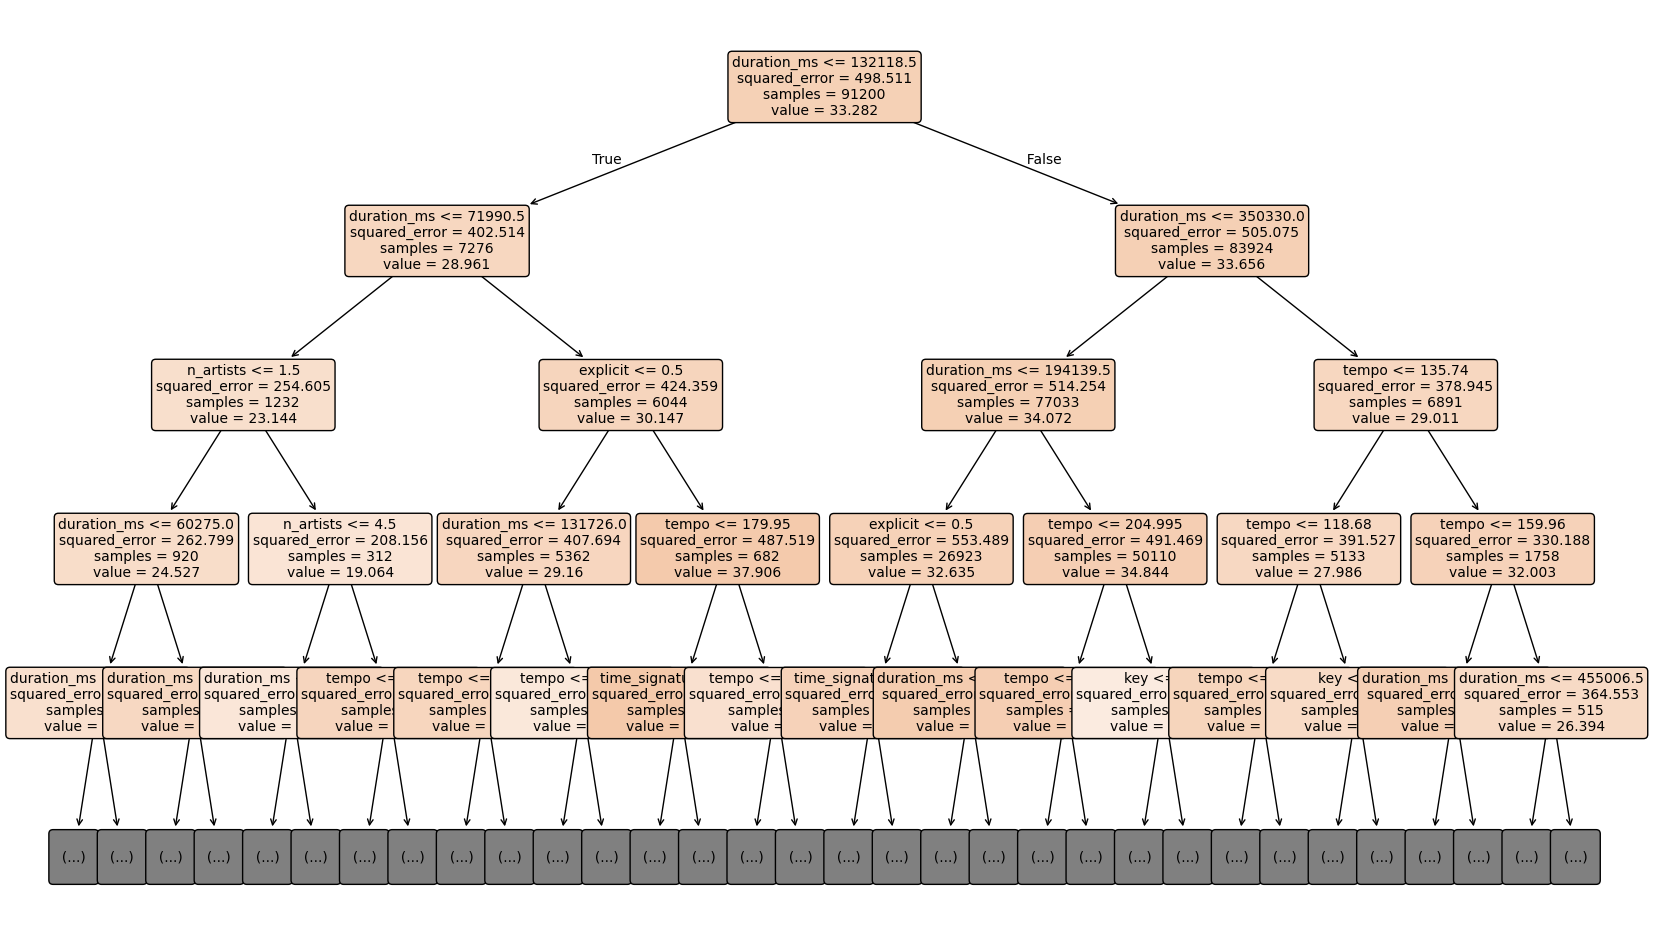

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

df = pd.read_csv("dataset.csv")
df["n_artists"] = df["artists"].apply(lambda x: len(str(x).split(';')))
# most songs have one artist, less than a quarter two, very few have more but they exist

features = [
    "n_artists",
    "duration_ms",
    "explicit",
    "key",
    "tempo",
    "time_signature",
]

X = df[features]
y = df["popularity"]

numeric_features = ["n_artists", "duration_ms", "explicit", "key", "tempo", "time_signature"]

model = Pipeline(steps=[
    ("tree", DecisionTreeRegressor(
        max_depth=8,     # safe default
        min_samples_split=20,
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

tree = model.named_steps["tree"]

all_features = numeric_features

imp = tree.feature_importances_

sorted_features = sorted(zip(imp, all_features), reverse=True)
for importance, name in sorted_features[:20]:
    print(f"{name}: {importance:.4f}")

visualize_decision_tree(model, features, max_depth=4)

We don't gain much from a basic decision tree on track metadata. Next we should try including one-hot genre categories to see if some genres are more important to popularity rating.

R²: 0.09215056249028608
RMSE: 21.166160353606646
track_genre_iranian: 0.1801
track_genre_romance: 0.1700
track_genre_pop-film: 0.1182
track_genre_latin: 0.1128
track_genre_k-pop: 0.0957
track_genre_detroit-techno: 0.0931
track_genre_chicago-house: 0.0865
track_genre_classical: 0.0856
n_artists: 0.0213
duration_ms: 0.0150
explicit: 0.0138
tempo: 0.0069
key: 0.0007
time_signature: 0.0004
track_genre_world-music: 0.0000
track_genre_turkish: 0.0000
track_genre_trip-hop: 0.0000
track_genre_trance: 0.0000
track_genre_techno: 0.0000
track_genre_tango: 0.0000


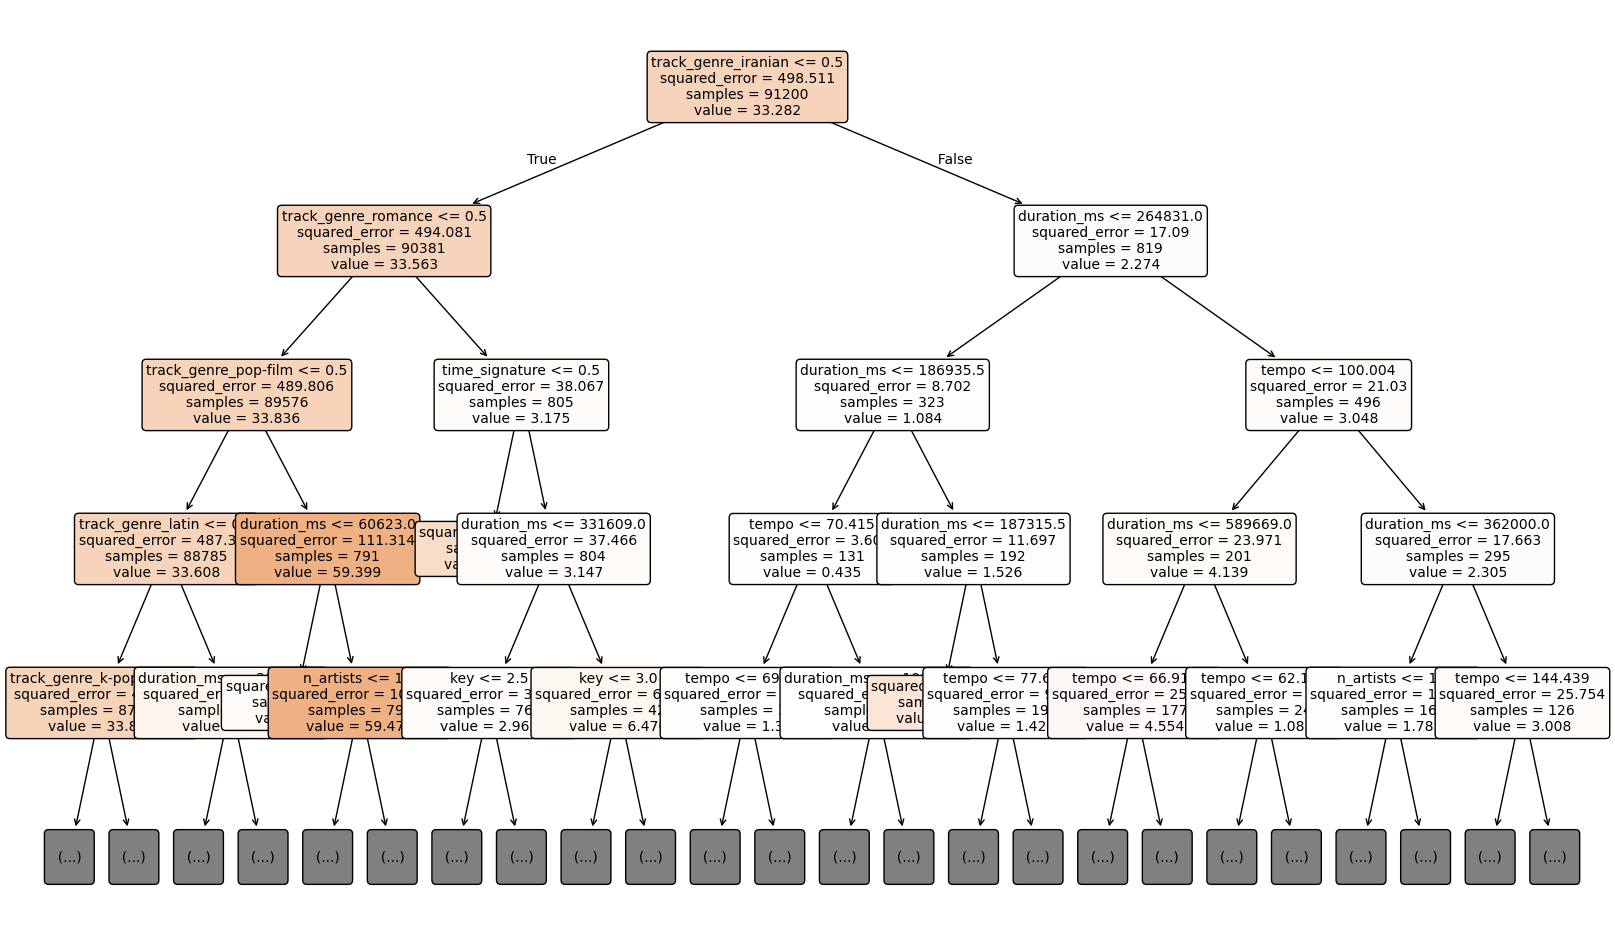

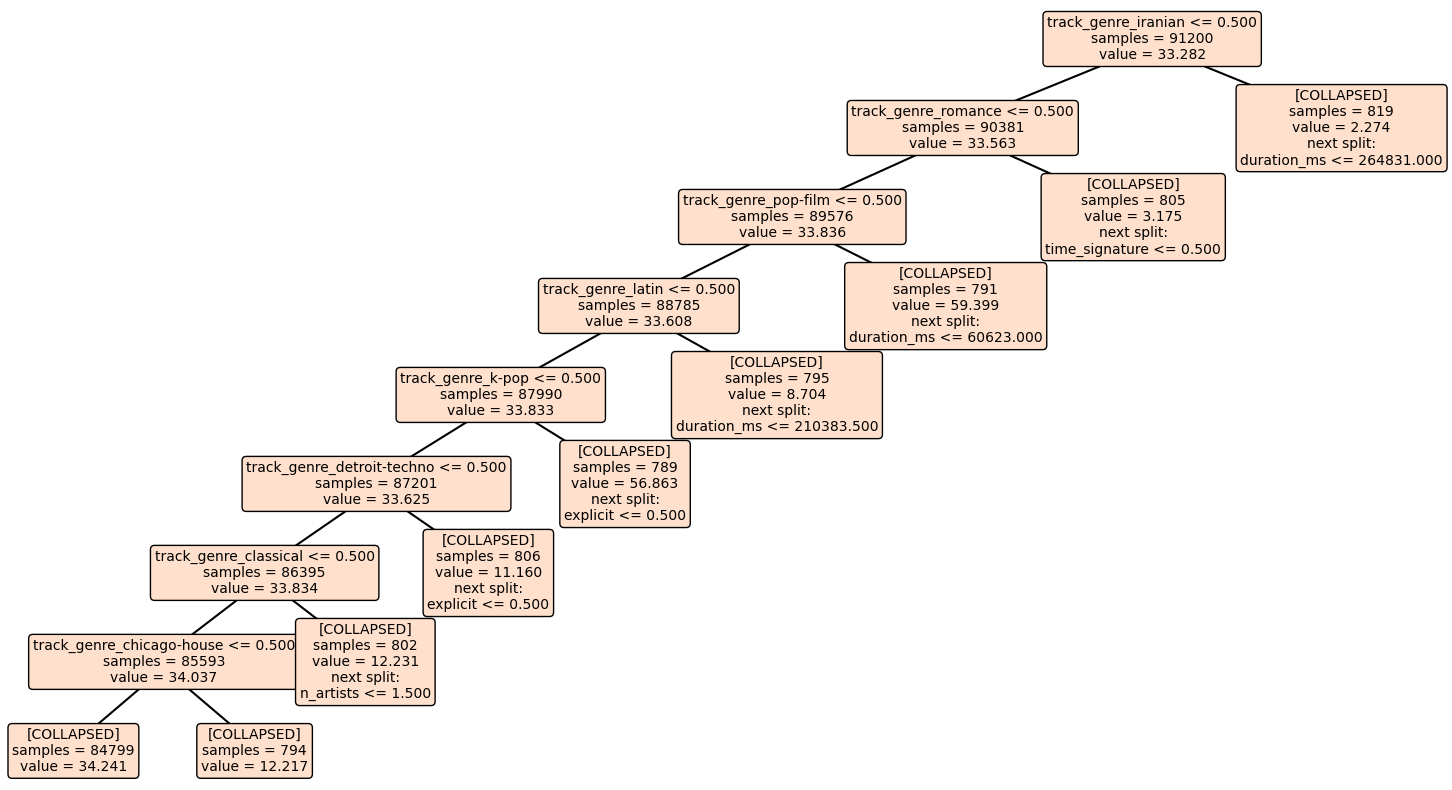

In [ ]:
features = [
    "n_artists",
    "duration_ms",
    "explicit",
    "key",
    "tempo",
    "time_signature",
    "track_genre"
]

X = df[features]
y = df["popularity"]

numeric_features = ["n_artists", "duration_ms", "explicit", "key", "tempo", "time_signature"]
categorical_features = ["track_genre"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("tree", DecisionTreeRegressor(
        max_depth=8,     # safe default
        min_samples_split=20,
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

tree = model.named_steps["tree"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
genre_features = ohe.get_feature_names_out(["track_genre"])

all_features = numeric_features
all_features = list(genre_features) + numeric_features

imp = tree.feature_importances_

sorted_features = sorted(zip(imp, all_features), reverse=True)
for importance, name in sorted_features[:20]:
    print(f"{name}: {importance:.4f}")

visualize_decision_tree(model, features, max_depth=4)
plot_condensed_tree(model, features, max_depth=8)

Both models end up being poor predictors of popularity, but when we include one-hot genres many of them become major predictors. Next we want to try looking at genres separately to see if any patterns emerge that could better predict a track's popularity within each genre.\
I would also like to note we see 'pop' genres with on-average higher popularity. This makes sense, pop is just an abbreviation for popular music and popularity ranking is done mostly by number of listens weighted by recent listens. 

In [5]:
df['track_genre'].value_counts()

track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64


=== Genre: sleep | R² = 0.5357 ===



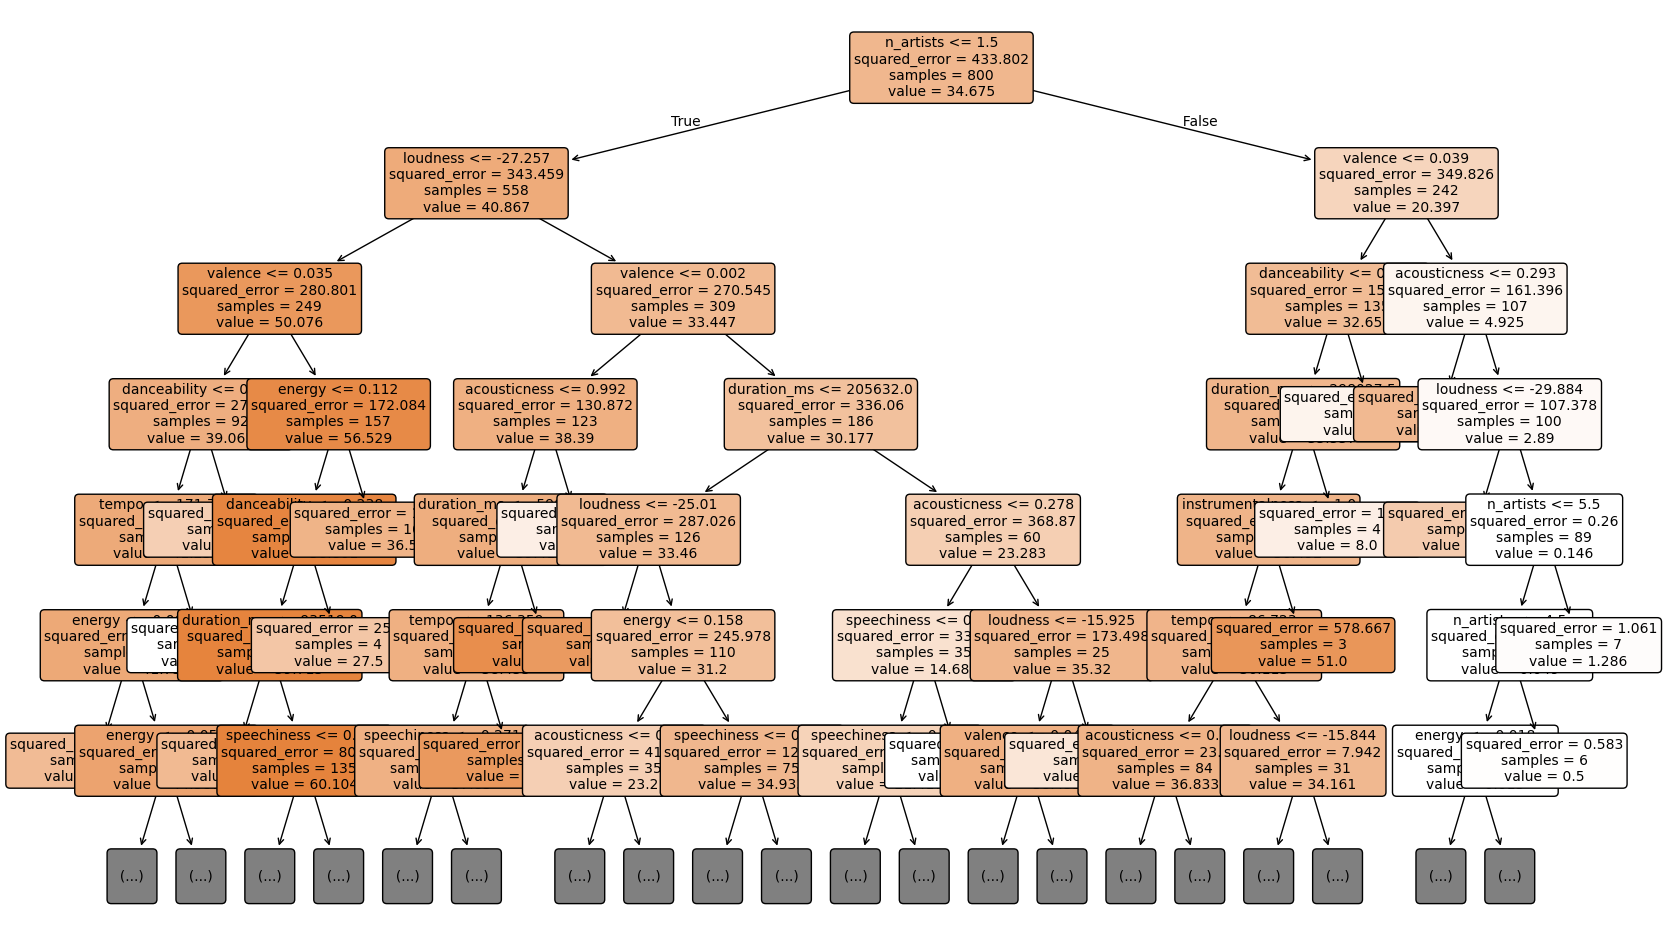


=== Genre: classical | R² = 0.4143 ===



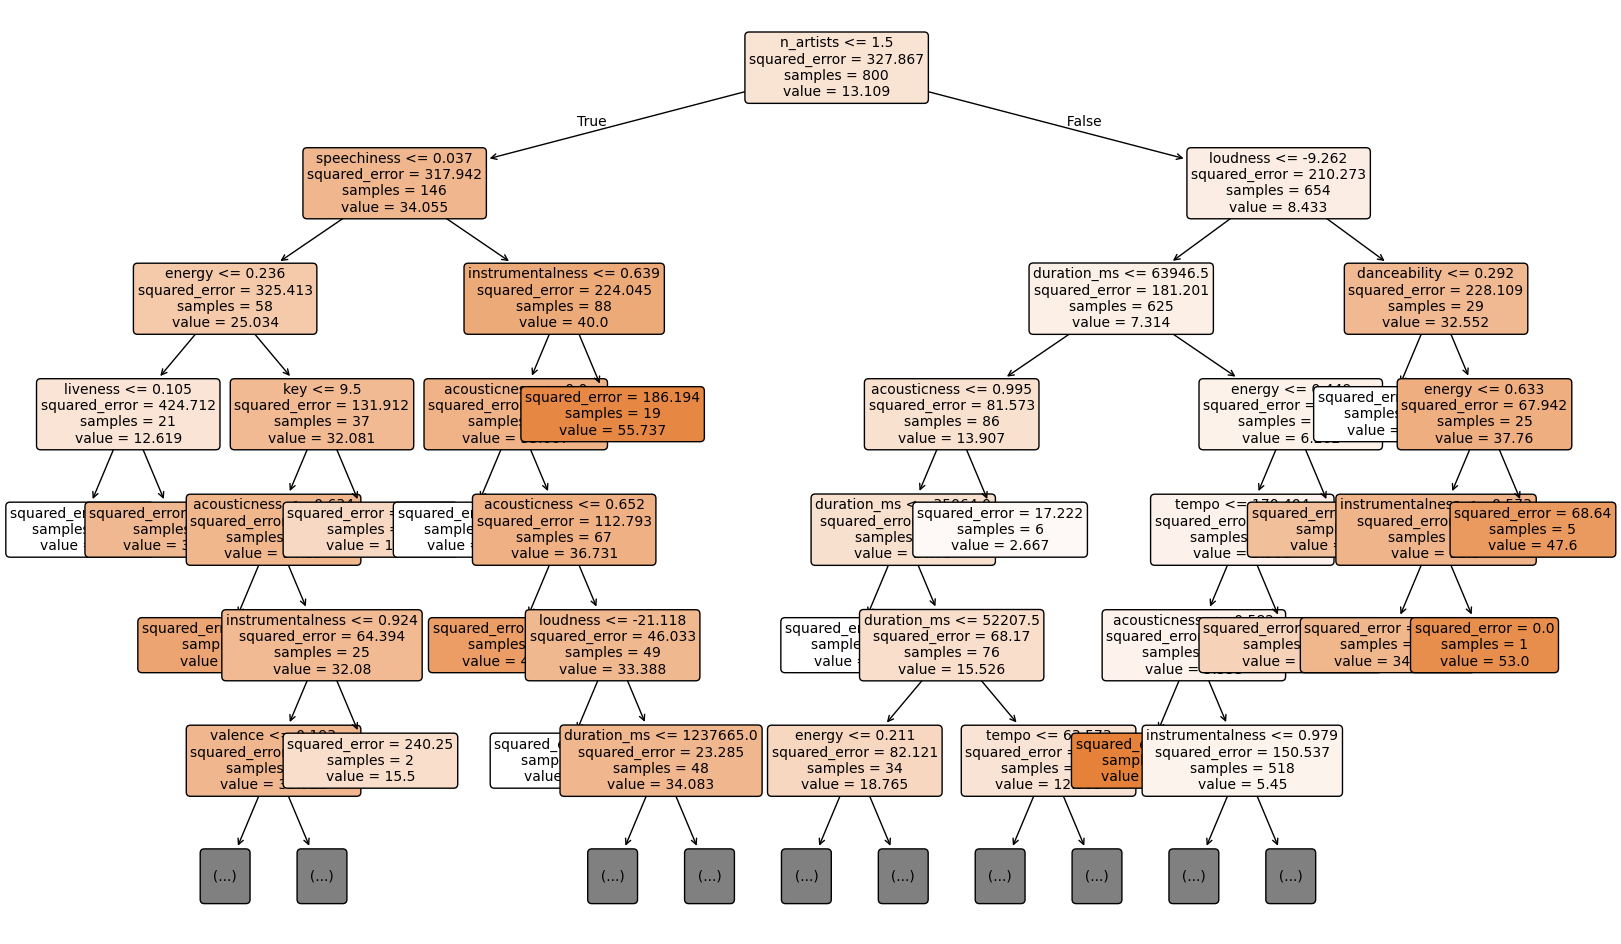


=== Genre: j-pop | R² = 0.2852 ===



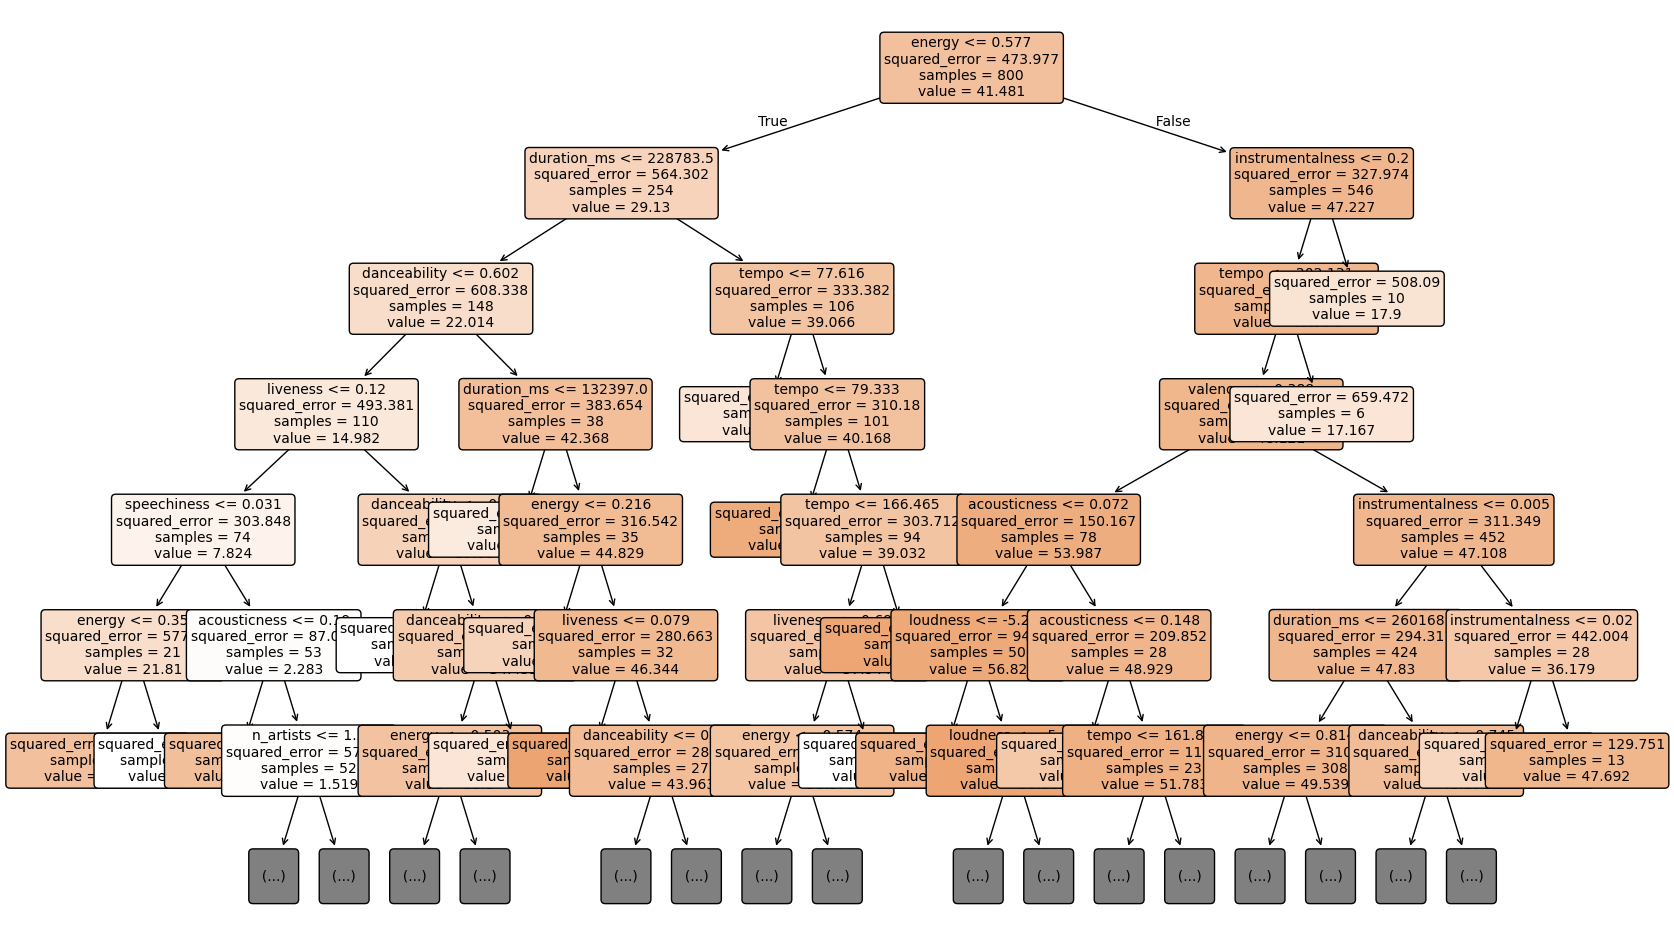

Saved results to genre_tree_results.csv


In [26]:
features = [
    "n_artists", "duration_ms", "explicit", "key", "tempo",
    "valence", "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness", "liveness"
]

results = []  # will hold dicts

all_genres = sorted(df["track_genre"].unique())

for genre in all_genres:
    sub = df[df["track_genre"] == genre]

    # Need enough rows
    if len(sub) < 200:   # adjustable threshold
        continue

    X = sub[features]
    y = sub["popularity"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train tree
    model = DecisionTreeRegressor(
        max_depth=8,
        min_samples_split=20,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Score
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)

    # Store results
    results.append({
        "genre": genre,
        "model": model,
        "score": r2,
        **{f"imp_{f}": imp for f, imp in zip(features, model.feature_importances_)}
    })

results_sorted = sorted(results, key=lambda d: d["score"], reverse=True)

top3 = results_sorted[:3]

for entry in top3:
    print(f"\n=== Genre: {entry['genre']} | R² = {entry['score']:.4f} ===\n")
    visualize_decision_tree(entry["model"], features, max_depth=6)

df_out = pd.DataFrame(results_sorted)
df_out.to_csv("genre_tree_results.csv", index=False)

print("Saved results to genre_tree_results.csv")


After building separate trees for each genre (and adding track metadata as features) we see a few trees that do a fair job representing the data.\
Sleep music was the easiest to explain, the popular songs in this genre are very quiet, low valence, low energy which is well-represented by our data.\
Our next best tree was for classical music. This tree separates songs with low energy, quiet, and more instrumentals (and less speech) than other genres.\
Our third best tree is J-Pop, at this point our tree loses most of its ability to explain the data. Though our r^2 score is a bit lacking, our first few splits are still great separators. First we see that most of our data isn't exceptionally high energy, high valence, and low instrumentalness. Popular songs tend to be higher tempo, positive songs with less focus on instrumentals\
Popularity, along with other trends, seem easier to track when we separate by genre.


## Graphing

We can make a graph connecting artists that have collaborated on the same album.

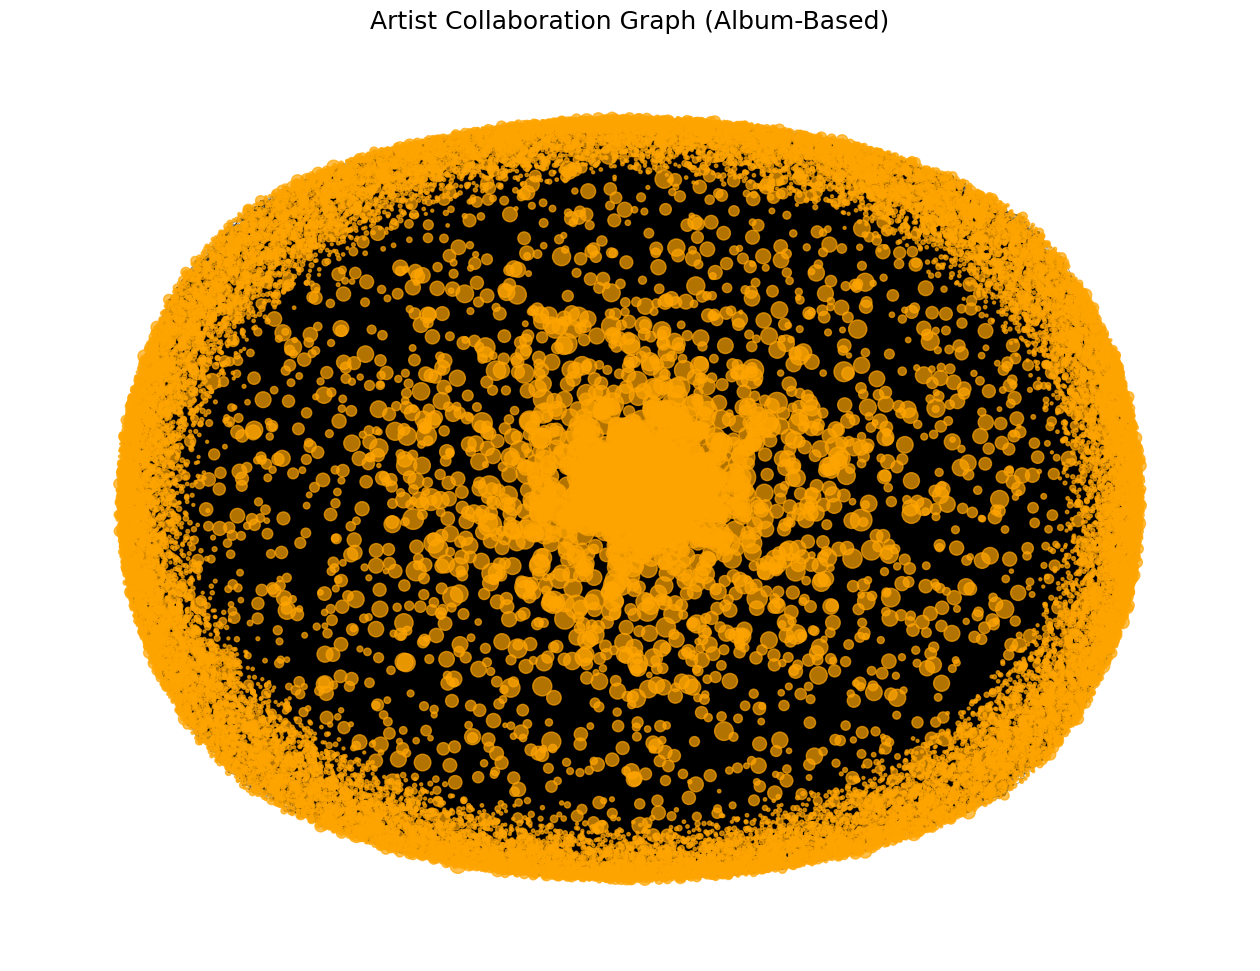

In [15]:
import itertools
import networkx as nx

df["artist_list"] = df["artists"].apply(lambda s: [a.strip() for a in str(s).split(";")])

G = nx.Graph()

for album, group in df.groupby("album_name"):
    # union of artists across all tracks in album
    artists = set()
    for lst in group["artist_list"]:
        artists.update(lst)
    
    # connect all pairs of artists within this album
    for a, b in itertools.combinations(sorted(artists), 2):
        if G.has_edge(a, b):
            G[a][b]["weight"] += 1   # increment collaboration count
        else:
            G.add_edge(a, b, weight=1, album=album)


plt.figure(figsize=(16, 12))

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Node sizes reflect degree
node_sizes = [3 + 1.5 * G.degree(n) for n in G.nodes()]

# Edge thickness represents collab weight
edge_widths = [0.5 * G[u][v]["weight"] for u, v in G.edges()]

# def sanitize_label(name):
    # return name.replace("$", r"\$")
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="orange", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
# labels = {n: sanitize_label(n) for n in G.nodes()}
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Artist Collaboration Graph (Album-Based)", fontsize=18)
plt.axis("off")
# plt.rcParams['text.usetex'] = False
# plt.rcParams['mathtext.default'] = 'regular'
plt.show()


In [9]:
num_components = nx.number_connected_components(G)
print("Number of connected components:", num_components)

components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

for i, comp in enumerate(components_sorted[:4], 1):  # print top 4 largest
    print(f"Component {i}: {len(comp)} artists")
print(f". . .")

largest = max(nx.connected_components(G), key=len)
print("Largest component size:", len(largest))

# k = nx.node_connectivity(G.subgraph(largest))
# print("Node connectivity of largest component:", k)

degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / len(degrees)
print("Average node degree:", avg_degree)


Number of connected components: 1722
Component 1: 17163 artists
Component 2: 26 artists
Component 3: 21 artists
Component 4: 18 artists
. . .
Largest component size: 17163
Average node degree: 13.871414351642386


Then we can run pagerank to find frequent connections between artists to find which artists frequently work together and combine their popular songs.

In [14]:
# 1) PageRank on the artist collaboration graph
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=20)

pr_df = (
    pd.DataFrame.from_dict(pagerank_scores, orient="index", columns=["pagerank"])
      .reset_index()
      .rename(columns={"index": "artist"})
)

# 2) Build per-artist metadata from df
#    - explode artist_list so each row is (track, single artist)
artist_meta = (
    df.explode("artist_list")
      .rename(columns={"artist_list": "artist"})
      .groupby("artist", as_index=False)
      .agg(
          avg_popularity=("popularity", "mean"),
          max_popularity=("popularity", "max"),
          track_count=("track_name", "nunique"),
          album_count=("album_name", "nunique"),
      )
)

# (Optional) If your df has a genre column, grab the most common genre per artist
genre_col = None
for col in ["track_genre", "genre", "genres"]:
    if col in df.columns:
        genre_col = col
        break

if genre_col is not None:
    artist_genre = (
        df.explode("artist_list")
          .rename(columns={"artist_list": "artist"})
          .groupby("artist")[genre_col]
          .agg(lambda s: s.value_counts().index[0])  # most frequent genre
          .reset_index()
          .rename(columns={genre_col: "top_genre"})
    )
    artist_meta = artist_meta.merge(artist_genre, on="artist", how="left")

# 3) Merge PageRank with metadata
artist_pr_meta = (
    pr_df.merge(artist_meta, on="artist", how="left")
         .sort_values("pagerank", ascending=False)
         .reset_index(drop=True)
)

# 4) Inspect top PageRank artists with popularity
artist_pr_meta.head(25)


artist  pagerank  avg_popularity  max_popularity  track_count  \
0         Arijit Singh  0.001208       59.295082              88          245   
1        Justin Bieber  0.001105       22.182353              89           48   
2               Pritam  0.001080       53.771772              88          313   
3         David Guetta  0.000889       20.292000              98           62   
4       Shreya Ghoshal  0.000850       57.376000              74           91   
5             J Balvin  0.000838       17.588235              88           78   
6          OneRepublic  0.000781       33.029268              96           71   
7      Ella Fitzgerald  0.000754        3.365019              67           31   
8        Stevie Wonder  0.000723        1.715481              75           18   
9           Katy Perry  0.000720       22.341772              80           20   
10      The Beach Boys  0.000682        7.764045              72           33   
11          Becky Hill  0.000659        8.090226              85           15   
12  Yuvan Shankar Raja  0.000658       52.557940              74          160   
13          Brenda Lee  0.000657        4.725000              71           13   
14            ILLENIUM  0.000631       42.000000              75          104   
15           Lady Gaga  0.000628        9.852941              84           28   
16           Burna Boy  0.000613       14.476636              83           57   
17       Nat King Cole  0.000603        1.215517              71           21   
18               Lizzo  0.000599        2.245283              89           12   
19              Tiësto  0.000592       25.886878              86           58   
20         Jack Harlow  0.000581        9.151786              86           24   
21        Daddy Yankee  0.000576       20.504000              85           52   
22        Robin Schulz  0.000570       15.090452              87           30   
23          Ed Sheeran  0.000566       16.380435              88           28   
24             Ava Max  0.000558       17.034884              86           22   

    album_count   top_genre  
0           184    pop-film  
1           106         pop  
2           138      indian  
3            79         edm  
4            88    pop-film  
5            88   reggaeton  
6            78       piano  
7            77       blues  
8            61        funk  
9            51       dance  
10           70  psych-rock  
11           37         edm  
12           94       k-pop  
13           63  rockabilly  
14           72     dubstep  
15           42       dance  
16           57   dancehall  
17           60        jazz  
18           43     hip-hop  
19           80      trance  
20           57     hip-hop  
21           69      latino  
22           54      german  
23           50         pop  
24           47       dance

Next lets take random walks and collect frequent artist-sets nearby a seed artist to find similar bands and make a playlist from their popular songs.

In [21]:
import random
from collections import Counter

def random_walk(G, start_node, walk_length=16):
    walk = [start_node]
    current = start_node
    
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break
        current = random.choice(neighbors)
        walk.append(current)
        
    return walk

def generate_random_walks(G, num_walks=5000, walk_length=16, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    walks = []
    
    for _ in range(num_walks):
        start = random.choice(nodes)
        walks.append(random_walk(G, start, walk_length))
        
    return walks

# Run once and reuse
artist_walks = generate_random_walks(G, num_walks=5000, walk_length=16)
len(artist_walks), artist_walks[0][:10]

def get_seed_baskets(artist_walks, seed_artist, window=5):
    """
    For each random walk containing seed_artist, extract a windowed segment
    around every occurrence of seed_artist and treat it as a basket.
    """
    seed_baskets = []
    
    for walk in artist_walks:
        if seed_artist not in walk:
            continue
        
        indices = [i for i, a in enumerate(walk) if a == seed_artist]
        
        for idx in indices:
            start = max(0, idx - window)
            end = min(len(walk), idx + window + 1)
            segment = walk[start:end]
            
            # Deduplicate but keep order
            seen = set()
            basket = []
            for a in segment:
                if a not in seen:
                    seen.add(a)
                    basket.append(a)
            seed_baskets.append(basket)
    
    return seed_baskets

def frequent_items_from_baskets(baskets, seed_artist=None, top_k=8, min_support=0.01):
    """
    Compute frequent single items from baskets and return top_k items
    sorted by support (fraction of baskets they appear in).
    """
    if not baskets:
        return []
    
    item_counts = Counter()
    num_baskets = len(baskets)
    
    for basket in baskets:
        uniq = set(basket)
        if seed_artist is not None and seed_artist in uniq:
            uniq.remove(seed_artist)
        for item in uniq:
            item_counts[item] += 1
    
    freq_items = []
    for item, count in item_counts.items():
        support = count / num_baskets
        if support >= min_support:
            freq_items.append((item, support, count))
    
    freq_items.sort(key=lambda x: x[1], reverse=True)
    return freq_items[:top_k]

def top_tracks_for_artist(df, artist, n=3, min_popularity=60):
    """
    Return top n tracks for a given artist, sorted by popularity,
    only including tracks with popularity >= min_popularity.
    
    Assumes df['artist_list'] is a list of artists per track and
    df['popularity'] is numeric.
    """
    # Tracks that include this artist
    mask_artist = df["artist_list"].apply(lambda lst: artist in lst)
    # Popularity filter
    mask_pop = df["popularity"] >= min_popularity
    
    subset = df.loc[mask_artist & mask_pop].copy()
    
    if subset.empty:
        return pd.DataFrame(columns=["artist", "track_name", "album_name", "popularity"])
    
    subset = (
        subset.assign(artist=artist)
              .sort_values("popularity", ascending=False)
              [["artist", "track_name", "album_name", "popularity"]]
              .drop_duplicates(subset=["track_name", "album_name"])
              .head(n)
    )
    return subset

def build_playlist_for_seed(df, artist_walks, seed_artist,
                            window=5, top_k_items=8,
                            tracks_per_item=3, min_support=0.01):
    # 1) Get local baskets around the seed artist
    baskets = get_seed_baskets(artist_walks, seed_artist, window=window)
    
    # 2) Get top frequent neighboring artists
    top_items = frequent_items_from_baskets(
        baskets,
        seed_artist=seed_artist,
        top_k=top_k_items,
        min_support=min_support
    )
    
    if not top_items:
        print(f"No frequent items found around '{seed_artist}'.")
        return pd.DataFrame()
    
    # 3) Collect tracks for each frequent artist
    playlist_parts = []
    for artist, support, count in top_items:
        tracks = top_tracks_for_artist(df, artist, n=tracks_per_item)
        if not tracks.empty:
            tracks = tracks.assign(
                seed_artist=seed_artist,
                neighbor_support=support,
                neighbor_count=count
            )
            playlist_parts.append(tracks)
    
    if not playlist_parts:
        return pd.DataFrame()
    
    playlist = pd.concat(playlist_parts, ignore_index=True)
    
    # De-duplicate tracks in case they appear under multiple artists
    playlist = playlist.drop_duplicates(subset=["track_name", "album_name"]).reset_index(drop=True)
    
    return playlist

# build playlist for a seed artist
playlist = build_playlist_for_seed(df, artist_walks, seed_artist="Stevie Wonder",
                                   window=5, top_k_items=15, tracks_per_item=3,
                                   min_support=0.01)

playlist.head(30)


artist  \
0                 Four Tops   
1              The Runaways   
2    Florence + The Machine   
3             Nat King Cole   
4             Nat King Cole   
5                Katy Perry   
6                Katy Perry   
7                Katy Perry   
8                      ABBA   
9                      ABBA   
10                     ABBA   
11               The Police   
12  Queens of the Stone Age   
13  Queens of the Stone Age   
14  Queens of the Stone Age   
15              Marvin Gaye   
16              Marvin Gaye   
17      Jay & The Americans   
18      Andrew Lloyd Webber   
19                     10cc   
20                     10cc   

                                           track_name  \
0        I Can't Help Myself (Sugar Pie, Honey Bunch)   
1                                         Cherry Bomb   
2                                     Never Let Me Go   
3                                             L-O-V-E   
4                                       Unforgettable   
5                     When I’m Gone (with Katy Perry)   
6                                   Harleys In Hawaii   
7                                          Dark Horse   
8                                       Dancing Queen   
9         Gimme! Gimme! Gimme! (A Man After Midnight)   
10                                          Angeleyes   
11                              Every Breath You Take   
12                                       No One Knows   
13                                   Go With The Flow   
14                                    Make It Wit Chu   
15                      Ain't No Mountain High Enough   
16                        Sexual Healing - Kygo Remix   
17                           Come A Little Bit Closer   
18  The Phantom Of the Opera - From 'The Phantom O...   
19                                    I'm Not In Love   
20                                  Dreadlock Holiday   

                                           album_name  popularity  \
0                              Four Tops Second Album          73   
1                                        The Runaways          69   
2               Ceremonials (Original Deluxe Version)          66   
3                                             L-O-V-E          71   
4                                       Unforgettable          67   
5                     When I’m Gone (with Katy Perry)          80   
6                                               Smile          78   
7                                               PRISM          78   
8                                             Arrival          83   
9                                         Voulez-Vous          82   
10                                        Voulez-Vous          78   
11                    Synchronicity (Remastered 2003)          86   
12                                 Songs For The Deaf          72   
13                                 Songs For The Deaf          68   
14                                       Era Vulgaris          63   
15                                             United          82   
16                        Sexual Healing (Kygo Remix)          64   
17  Come A Little Bit Closer: The Best Of Jay & Th...          65   
18  The Phantom Of The Opera (Original Motion Pict...          62   
19                            The Original Soundtrack          71   
20                                    Bloody Tourists          69   

      seed_artist  neighbor_support  neighbor_count  
0   Stevie Wonder          0.117647               4  
1   Stevie Wonder          0.117647               4  
2   Stevie Wonder          0.117647               4  
3   Stevie Wonder          0.088235               3  
4   Stevie Wonder          0.088235               3  
5   Stevie Wonder          0.088235               3  
6   Stevie Wonder          0.088235               3  
7   Stevie Wonder          0.088235               3  
8   Stevie Wonder          0.088235               3  
9   Stevie Wonder       

This playlist isn't very cohesive, we get some similar artists like the Four Top, Marvin Gaye, and 10cc, but we had many songs that don't quite fit Stevie's style.
lets see where these artists are on our graph

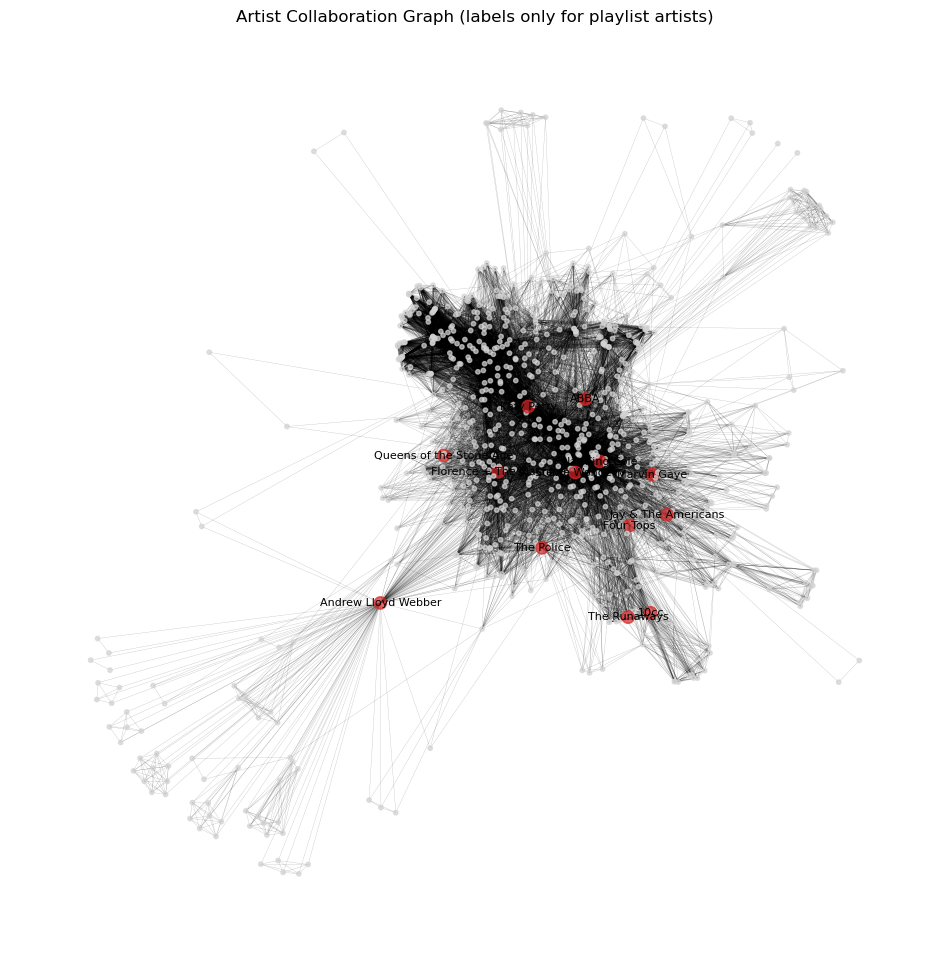

In [24]:
# 1) Collect the artists that appear in the playlist
playlist_artists = set(playlist["artist"].unique())
playlist_artists.add("Stevie Wonder")

neighbors = set()
for a in playlist_artists:
    if a in G:
        neighbors.update(G.neighbors(a))

H = G.subgraph(playlist_artists | neighbors).copy()

# Optionally also include the seed artist itself
if "seed_artist" in playlist.columns:
    playlist_artists.update(playlist["seed_artist"].unique())

# 2) Tag nodes in H
nx.set_node_attributes(H, False, "in_playlist")
for a in playlist_artists:
    if a in H:
        H.nodes[a]["in_playlist"] = True

# 3) Build label dict: only label playlist artists
labels = {
    node: node
    for node, data in H.nodes(data=True)
    if data.get("in_playlist", False)
}

# 4) (Optional) Different colors for playlist vs others
node_colors = [
    "tab:red" if H.nodes[n].get("in_playlist", False) else "lightgray"
    for n in H.nodes()
]

node_sizes = [
    80 if H.nodes[n].get("in_playlist", False) else 10
    for n in H.nodes()
]

# 5) Draw the graph
pos = nx.spring_layout(H, seed=42)  # or reuse your existing layout

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(H, pos, width=0.2, alpha=0.3)
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("Artist Collaboration Graph (labels only for playlist artists)")
plt.axis("off")
plt.show()

In [25]:
source = "The Runaways"
target = "10cc"

if source not in G:
    print(f"'{source}' not found in G")
elif target not in G:
    print(f"'{target}' not found in G")
else:
    try:
        path = nx.shortest_path(G, source=source, target=target)
        print("Shortest path from", source, "to", target, ":\n")
        for i, artist in enumerate(path):
            print(f"{i}: {artist}")
        print("\nPath length (edges):", len(path) - 1)
    except nx.NetworkXNoPath:
        print(f"No path between '{source}' and '{target}' in this graph.")

Shortest path from The Runaways to 10cc :

0: The Runaways
1: 10cc

Path length (edges): 1


In [33]:
artists_to_check = ["10cc", "The Runaways"]

for artist in artists_to_check:
    # rows where this artist appears in artist_list
    mask = df["artist_list"].apply(lambda lst: artist in lst)
    artist_df = df.loc[mask]

    # unique albums
    albums = (
        artist_df[["album_name"]]
        .dropna()
        .drop_duplicates()
        .sort_values("album_name")
    )

    print(f"\nAlbums for {artist} ({len(albums)} total):")
    print(albums["album_name"].to_string(index=False))

mask = (
    (df["album_name"] == "On air 70's Hits")
    & df["artist_list"].apply(lambda lst: ("10cc" in lst) or ("The Runaways" in lst))
)
print(df.loc[mask, "track_name"])



Albums for 10cc (4 total):
        Bloody Tourists
    Fiesta temática 70s
       On air 70's Hits
The Original Soundtrack

Albums for The Runaways (2 total):
On air 70's Hits
    The Runaways
8321      The Things We Do For Love
34691     The Things We Do For Love
86441                   Cherry Bomb
99695     The Things We Do For Love
102695    The Things We Do For Love
Name: track_name, dtype: object


So we see compilation albums connecting artists whereas I expect collaborations between like-minded artists. I looked up this album on spotify and it no longer exists, but this shows we should try connecting songs rather than artists.

In [37]:
mask = (
    (df["popularity"] >= 65)
)
print(len(df.loc[mask]))

9477


Popular subgraph size (pop >= 65): 5534 nodes, 8043 edges


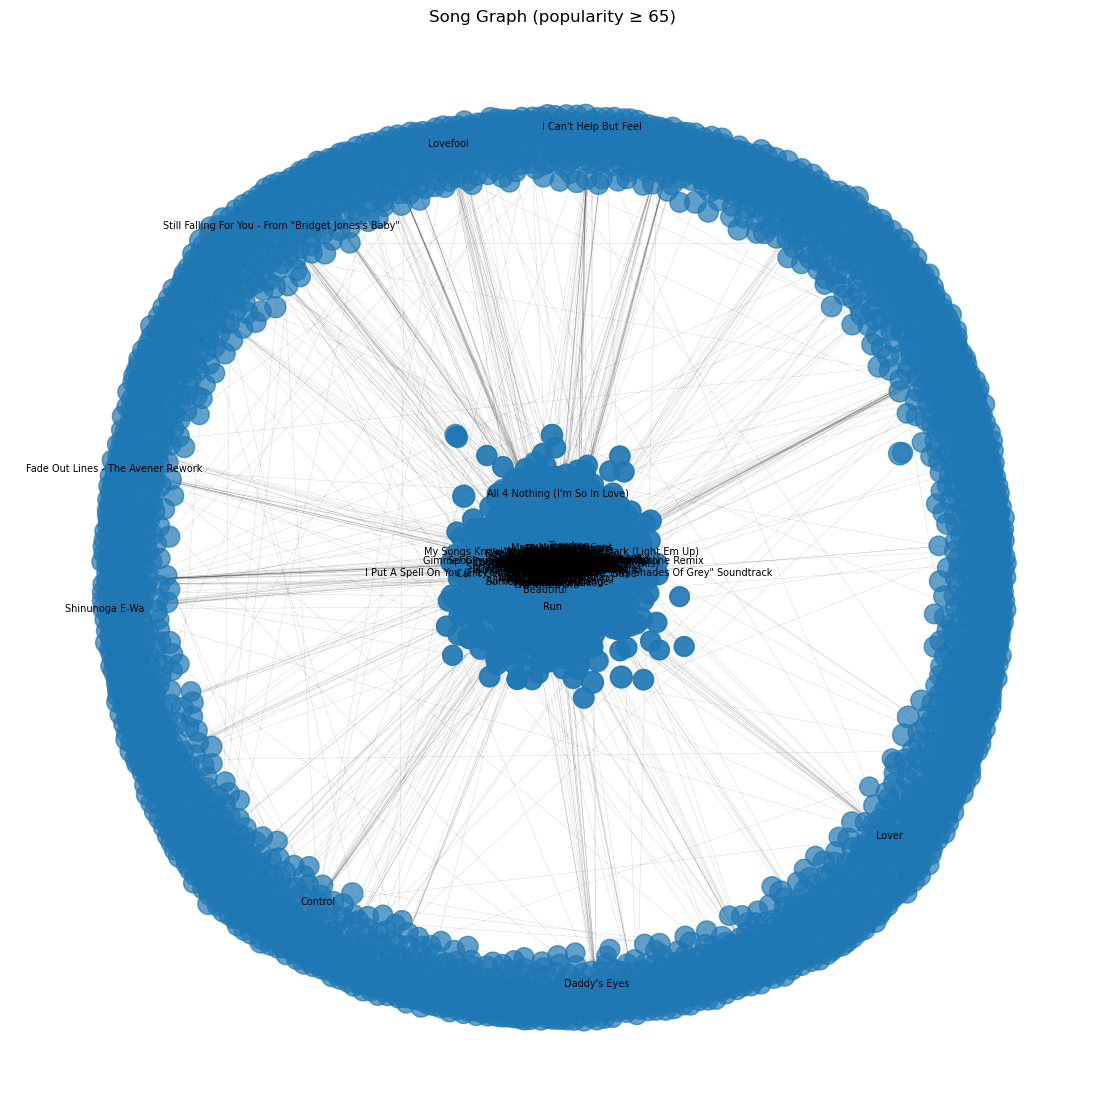

In [40]:
# 1) Build a canonical song_id for each row: (track_name, tuple(artist_list))
df["song_id"] = df.apply(
    lambda row: (row["track_name"], tuple(row["artist_list"])),
    axis=1
)

# 2) Initialize song-level graph
GS = nx.Graph()

# 3) Add nodes for each unique song_id, aggregating popularity if needed
for song_id, group in df.groupby("song_id"):
    # group contains all rows for this (track_name, artist_list) across albums
    track_name = group["track_name"].iloc[0]
    artist_list = group["artist_list"].iloc[0]
    # you can choose mean, max, etc. Here we use max popularity across appearances
    popularity = group["popularity"].max()

    GS.add_node(
        song_id,
        track_name=track_name,
        artist_list=artist_list,
        popularity=popularity
    )

# 4) Connect songs that appear on the same album
for album, group in df.groupby("album_name"):
    # ensure song_id exists for all rows
    if "song_id" not in group.columns:
        group = group.assign(
            song_id=group.apply(
                lambda row: (row["track_name"], tuple(row["artist_list"])),
                axis=1
            )
        )

    # unique songs on this album
    album_songs = (
        group[["song_id", "popularity"]]
        .drop_duplicates("song_id")
    )

    song_ids = album_songs["song_id"].tolist()
    pops = dict(zip(album_songs["song_id"], album_songs["popularity"]))

    # connect all pairs of songs on this album
    for s1, s2 in itertools.combinations(song_ids, 2):
        # edge weight: average popularity of the two songs on this album
        w = (pops[s1] + pops[s2]) / 2.0

        if GS.has_edge(s1, s2):
            GS[s1][s2]["weight"] += w
            GS[s1][s2]["album_count"] += 1
            GS[s1][s2]["albums"].add(album)
        else:
            GS.add_edge(
                s1, s2,
                weight=w,
                album_count=1,
                albums={album}
            )


def song_graph_popular_subgraph(GS, min_popularity=65):
    """Return subgraph of GS with only songs having popularity >= min_popularity."""
    popular_nodes = [
        n for n, data in GS.nodes(data=True)
        if data.get("popularity", 0) >= min_popularity
    ]
    H = GS.subgraph(popular_nodes).copy()
    print(f"Popular subgraph size (pop >= {min_popularity}): {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")
    return H

def visualize_song_graph_popular(GS, min_popularity=65, max_nodes=None, seed=42):
    """
    Visualize song graph filtered by popularity.
    If max_nodes is given, keep only top-degree nodes from the filtered graph.
    """
    H = song_graph_popular_subgraph(GS, min_popularity=min_popularity)

    if max_nodes is not None and H.number_of_nodes() > max_nodes:
        # keep only top-degree nodes
        nodes_by_deg = sorted(H.degree, key=lambda x: x[1], reverse=True)
        keep_nodes = [n for n, d in nodes_by_deg[:max_nodes]]
        H = H.subgraph(keep_nodes).copy()
        print(f"Further reduced to top-degree subgraph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

    # layout
    pos = nx.spring_layout(H, seed=seed)

    # node sizes scaled by popularity
    pops = nx.get_node_attributes(H, "popularity")
    node_sizes = [max(pops.get(n, 1), 1) * 3 for n in H.nodes()]

    # labels: track_name, but only for highest-degree nodes to keep it readable
    nodes_by_deg = sorted(H.degree, key=lambda x: x[1], reverse=True)
    label_nodes = {n for n, d in nodes_by_deg[:200]}  # label top 200 by degree
    labels = {
        n: H.nodes[n].get("track_name", "")
        for n in H.nodes()
        if n in label_nodes
    }

    plt.figure(figsize=(14, 14))
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(H, pos, width=0.2, alpha=0.25)
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=7)

    plt.title(f"Song Graph (popularity ≥ {min_popularity})")
    plt.axis("off")
    plt.show()

visualize_song_graph_popular(GS, min_popularity=65, max_nodes=None)

In [49]:
print("Song graph GS:")
print("Nodes:", GS.number_of_nodes())
print("Edges:", GS.number_of_edges())

# connected components
components = sorted(nx.connected_components(GS), key=len, reverse=True)
num_components = len(components)
largest_comp = components[0]

print("Number of connected components:", num_components)
print("Largest component size:", len(largest_comp))

# show sizes of first few components
print("\nTop 10 component sizes:")
for i, comp in enumerate(components[:10], start=1):
    print(f"Component {i}: {len(comp)} nodes")

# basic degree stats on GS and the giant component
degrees = dict(GS.degree())
avg_degree = sum(degrees.values()) / len(degrees)
print("\nAverage node degree (GS):", avg_degree)

GC = GS.subgraph(largest_comp)
degrees_gc = dict(GC.degree())
avg_degree_gc = sum(degrees_gc.values()) / len(degrees_gc)
print("Average node degree (largest component):", avg_degree_gc)


Song graph GS:
Nodes: 81344
Edges: 208133
Number of connected components: 43039
Largest component size: 5187

Top 10 component sizes:
Component 1: 5187 nodes
Component 2: 490 nodes
Component 3: 231 nodes
Component 4: 93 nodes
Component 5: 89 nodes
Component 6: 89 nodes
Component 7: 68 nodes
Component 8: 62 nodes
Component 9: 59 nodes
Component 10: 54 nodes

Average node degree (GS): 5.11735346184107
Average node degree (largest component): 28.212068633121266


In [54]:
def random_walk(G, start_node, walk_length=16, weighted=False, alpha=1.0, eps=1e-3):
    """
    Random walk from start_node.
    If weighted=True, choose next node with probability proportional to
    (neighbor_popularity + eps)**alpha.
    """
    walk = [start_node]
    current = start_node
    
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break
        
        if not weighted:
            current = random.choice(neighbors)
        else:
            # popularity-based weights
            weights = []
            for n in neighbors:
                pop = G.nodes[n].get("popularity", 0.0) or 0.0
                w = (pop + eps) ** alpha
                weights.append(w)
            current = random.choices(neighbors, weights=weights, k=1)[0]
        
        walk.append(current)
        
    return walk


def generate_song_walks(GS,
                        num_walks=5000,
                        walk_length=16,
                        seed=42,
                        start_node=None,
                        weighted=False,
                        alpha=1.0):
    """
    Generate random walks on GS.
    If start_node is given, all walks start from that song.
    If weighted=True, transitions are popularity-weighted.
    """
    random.seed(seed)
    nodes = list(GS.nodes())
    walks = []
    
    for _ in range(num_walks):
        if start_node is None:
            s = random.choice(nodes)
        else:
            s = start_node
        walks.append(random_walk(GS, s, walk_length, weighted=weighted, alpha=alpha))
        
    return walks

# run once
song_walks = generate_song_walks(GS, num_walks=5000, walk_length=16)


def get_seed_song_id(df, track_name, artist=None, min_popularity=65):
    """
    Find a song_id by track_name (and optional artist substring).
    If multiple rows match, pick the most popular one.
    """
    sub = df[df["track_name"] == track_name].copy()
    
    if artist is not None:
        sub = sub[sub["artist_list"].apply(lambda lst: any(artist in a for a in lst))]
    
    if min_popularity is not None:
        sub = sub[sub["popularity"] >= min_popularity]
    
    if sub.empty:
        raise ValueError(f"No songs found for '{track_name}' (artist={artist}) with given filters.")
    
    row = sub.sort_values("popularity", ascending=False).iloc[0]
    return row["song_id"]


def build_song_playlist_from_walks(df,
                                   GS,
                                   song_walks,
                                   seed_song_id,
                                   window=5,
                                   top_k_items=30,
                                   min_support=0.01,
                                   min_popularity=0):
    """
    Use random walks on GS and frequent itemsets in windows around seed_song_id
    to build a playlist of songs directly.
    """
    # 1) Get local baskets around the seed song
    baskets = get_seed_baskets(song_walks, seed_song_id, window=window)
    
    # 2) Frequent neighboring songs (song_ids)
    top_items = frequent_items_from_baskets(
        baskets,
        seed_artist=seed_song_id,   # parameter name is 'seed_artist' but it’s just the item to exclude
        top_k=top_k_items,
        min_support=min_support
    )
    
    if not top_items:
        print(f"No frequent songs found around {seed_song_id}.")
        return pd.DataFrame()
    
    playlist_rows = []
    
    for song_id, support, count in top_items:
        if song_id not in GS:
            continue
        
        node_data = GS.nodes[song_id]
        track_name = node_data.get("track_name")
        artist_list = list(node_data.get("artist_list", []))
        popularity = node_data.get("popularity", None)
        
        # popularity filter if desired
        if popularity is not None and popularity < min_popularity:
            continue
        
        # albums: look back into df via song_id
        album_names = (
            df.loc[df["song_id"] == song_id, "album_name"]
              .dropna()
              .drop_duplicates()
              .tolist()
        )
        album_name = album_names[0] if album_names else None
        
        playlist_rows.append({
            "song_id": song_id,
            "track_name": track_name,
            "artists": "; ".join(artist_list),
            "album_name": album_name,
            "popularity": popularity,
            "neighbor_support": support,
            "neighbor_count": count,
        })
    
    if not playlist_rows:
        return pd.DataFrame()
    
    playlist = pd.DataFrame(playlist_rows)
    
    # De-duplicate songs (song_id already unique, but just in case)
    playlist = playlist.drop_duplicates(subset=["song_id"]).reset_index(drop=True)
    
    return playlist

# 1) choose seed song directly
seed_song_id = get_seed_song_id(df, "Dancing Queen", artist="ABBA", min_popularity=50)

# 2) generate walks starting from that song, optionally popularity-weighted
song_walks = generate_song_walks(
    GS,
    num_walks=5000,
    walk_length=16,
    seed=42,
    start_node=seed_song_id,
    weighted=True,
    alpha=1.0        # strength of popularity bias
)

# 3) build playlist from those walks
song_playlist = build_song_playlist_from_walks(
    df=df,
    GS=GS,
    song_walks=song_walks,
    seed_song_id=seed_song_id,
    window=5,
    top_k_items=30,
    min_support=0.01,
    min_popularity=60,
)

song_playlist.head(30)


song_id  \
0                     (Summer Of '69, (Bryan Adams,))   
1   (Karma Chameleon - Remastered 2002, (Culture C...   
2   (Night Fever - From "Saturday Night Fever" Sou...   
3                      (Money, Money, Money, (ABBA,))   
4               (Partyanimal, (Micha von der Rampe,))   
5                  (Knowing Me, Knowing You, (ABBA,))   
6          (The Boys Are Back In Town, (Thin Lizzy,))   
7               (Reelin' In The Years, (Steely Dan,))   
8                          (My Sharona, (The Knack,))   
9                      (Heat Waves, (Glass Animals,))   
10               (When I Kissed The Teacher, (ABBA,))   
11                                (Fernando, (ABBA,))   
12  (Can't Get Enough Of Your Love, Babe, (Barry W...   
13            (Sweet Home Alabama, (Lynyrd Skynyrd,))   
14                                (Waterloo, (ABBA,))   
15                 (Somewhere Only We Know, (Keane,))   
16                        (bad guy, (Billie Eilish,))   
17         (Fingers Crossed, (Lauren Spencer Smith,))   
18                   (One Way Or Another, (Blondie,))   
19                    (Layla, (Derek & The Dominos,))   
20                   (Counting Stars, (OneRepublic,))   
21                       (Heart Of Glass, (Blondie,))   
22                    (No Lie, (Sean Paul, Dua Lipa))   
23                       (Layla, (DJ Robin, Schürze))   
24               (Call Me Maybe, (Carly Rae Jepsen,))   
25               (Dicht im Flieger, (Julian Sommer,))   
26                   (Numb Little Bug, (Em Beihold,))   
27         (Scars To Your Beautiful, (Alessia Cara,))   

                                           track_name               artists  \
0                                       Summer Of '69           Bryan Adams   
1                   Karma Chameleon - Remastered 2002          Culture Club   
2   Night Fever - From "Saturday Night Fever" Soun...              Bee Gees   
3                                 Money, Money, Money                  ABBA   
4                                         Partyanimal   Micha von der Rampe   
5                             Knowing Me, Knowing You                  ABBA   
6                           The Boys Are Back In Town            Thin Lizzy   
7                                Reelin' In The Years            Steely Dan   
8                                          My Sharona             The Knack   
9                                          Heat Waves         Glass Animals   
10                          When I Kissed The Teacher                  ABBA   
11                                           Fernando                  ABBA   
12                Can't Get Enough Of Your Love, Babe           Barry White   
13                                 Sweet Home Alabama        Lynyrd Skynyrd   
14                                           Waterloo                  ABBA   
15                             Somewhere Only We Know                 Keane   
16                                            bad guy         Billie Eilish   
17                                    Fingers Crossed  Lauren Spencer Smith   
18                                 One Way Or Another               Blondie   
19                                              Layla   Derek & The Dominos   
20                                     Counting Stars           OneRepublic   
21                                     Heart Of Glass               Blondie   
22                                             No Lie   Sean Paul; Dua Lipa   
23                                              Layla     DJ Robin; Schürze   
24                                      Call Me Maybe      Carly Rae Jepsen   
25                                   Dicht im Flieger         Julian Sommer   
26                                    Numb Little Bug            Em Beihold   
27                            Scars To Your Beautiful          Alessia Cara   

                                           album_name  popularity  \
0        Reckless (30th Anniver

MUCH more cohesive playlist, we get songs that I would put on an ABBA sort of party playlist. Karma Chameleon, The Boys Are Back In Town, Reelin' In The Years, My Sharona, Sweet Home Alabama, bad guy, Heart of Glass, great songs to group with Dancing Queen.

In [63]:
seed_song_id = get_seed_song_id(df, "All The Small Things", artist="blink-182", min_popularity=60)

song_walks = generate_song_walks(
    GS,
    num_walks=5000,
    walk_length=16,
    seed=42,
    start_node=seed_song_id,
    weighted=True,
    alpha=1.0        # strength of popularity bias
)

song_playlist = build_song_playlist_from_walks(
    df=df,
    GS=GS,
    song_walks=song_walks,
    seed_song_id=seed_song_id,
    window=5,
    top_k_items=30,
    min_support=0.01,
    min_popularity=60,
)

song_playlist.head(30)

song_id  \
0                          (All Star, (Smash Mouth,))   
1                    (Mr. Brightside, (The Killers,))   
2                  (Somewhere Only We Know, (Keane,))   
3                       (Thunder, (Imagine Dragons,))   
4                   (Livin' On A Prayer, (Bon Jovi,))   
5                          (Don't Speak, (No Doubt,))   
6                            (Buddy Holly, (Weezer,))   
7                        (Zombie, (The Cranberries,))   
8            (Don't You Want Me, (The Human League,))   
9                        (Free Fallin', (Tom Petty,))   
10                   (Everybody Talks, (Neon Trees,))   
11                   (The Middle, (Jimmy Eat World,))   
12                        (The Reason, (Hoobastank,))   
13                      (American Pie, (Don McLean,))   
14  (Everybody Wants To Rule The World, (Tears For...   
15          (Sugar, We're Goin Down, (Fall Out Boy,))   
16  (Have You Ever Seen The Rain, (Creedence Clear...   
17      (Gives You Hell, (The All-American Rejects,))   
18                       (Say It Ain't So, (Weezer,))   
19                      (Kryptonite, (3 Doors Down,))   
20                          (No Rain, (Blind Melon,))   
21               (What's My Age Again?, (blink-182,))   
22            (You're Still The One, (Shania Twain,))   
23                  (Rock And Roll All Nite, (KISS,))   
24                                  (Lonely, (Akon,))   
25                  (Friday I'm In Love, (The Cure,))   
26         (The Boys Are Back In Town, (Thin Lizzy,))   
27                 (Somebody Told Me, (The Killers,))   
28  (Start Me Up - Remastered 2009, (The Rolling S...   
29       (Put Your Records On, (Corinne Bailey Rae,))   

                           track_name                       artists  \
0                            All Star                   Smash Mouth   
1                      Mr. Brightside                   The Killers   
2              Somewhere Only We Know                         Keane   
3                             Thunder               Imagine Dragons   
4                  Livin' On A Prayer                      Bon Jovi   
5                         Don't Speak                      No Doubt   
6                         Buddy Holly                        Weezer   
7                              Zombie               The Cranberries   
8                   Don't You Want Me              The Human League   
9                        Free Fallin'                     Tom Petty   
10                    Everybody Talks                    Neon Trees   
11                         The Middle               Jimmy Eat World   
12                         The Reason                    Hoobastank   
13                       American Pie                    Don McLean   
14  Everybody Wants To Rule The World               Tears For Fears   
15             Sugar, We're Goin Down                  Fall Out Boy   
16        Have You Ever Seen The Rain  Creedence Clearwater Revival   
17                     Gives You Hell      The All-American Rejects   
18                    Say It Ain't So                        Weezer   
19                         Kryptonite                  3 Doors Down   
20                            No Rain                   Blind Melon   
21               What's My Age Again?                     blink-182   
22               You're Still The One                  Shania Twain   
23             Rock And Roll All Nite                          KISS   
24                             Lonely                          Akon   
25                 Friday I'm In Love                      The Cure   
26          The Boys Are Back In Town                    Thin Lizzy   
27                   Somebody Told Me                   The Killers   
28      Start Me Up - Remastered 2009            The Rolling Stones   
29                Put Your Records On            Corinne Bailey Rae   

                                         album_name  popularity  \
0        